In [ ]:
pip install face_recognition

In [ ]:
import os
from imutils import paths
import face_recognition
import pickle
import cv2

DATASET_PATH = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled"

print("[INFO] start processing faces...")
imagePaths = list(paths.list_images(DATASET_PATH))
knownEncodings = []
knownNames = []

for (i, imagePath) in enumerate(imagePaths):
    print(f"[INFO] processing image {i + 1}/{len(imagePaths)}")
    name = imagePath.split(os.path.sep)[-2]  # Extract folder name as label
    
    image = cv2.imread(imagePath)
    if image is None:
        print(f"[WARNING] Could not read image {imagePath}, skipping.")
        continue

    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = face_recognition.face_locations(rgb, model="hog")
    encodings = face_recognition.face_encodings(rgb, boxes)

    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)

print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
with open("encodings.pickle", "wb") as f:
    f.write(pickle.dumps(data))

print("[INFO] Training complete. Encodings saved to 'encodings.pickle'")


### Test on single image 

In [1]:
import face_recognition
import cv2
import pickle
import os

# Load encodings
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

# Replace this with your actual image
image_path = "/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg"

# Check file exists
if not os.path.exists(image_path):
    print(f"[ERROR] Image not found at: {image_path}")
    exit()

# Load the image
image = cv2.imread(image_path)
if image is None:
    print(f"[ERROR] Failed to read image: {image_path}")
    exit()

# Convert to RGB
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect and encode
boxes = face_recognition.face_locations(rgb, model="hog")
encodings = face_recognition.face_encodings(rgb, boxes)

for (box, encoding) in zip(boxes, encodings):
    matches = face_recognition.compare_faces(data["encodings"], encoding)
    name = "Unknown"

    if True in matches:
        matchedIdxs = [i for (i, b) in enumerate(matches) if b]
        counts = {}
        for i in matchedIdxs:
            counts[data["names"][i]] = counts.get(data["names"][i], 0) + 1
        name = max(counts, key=counts.get)

    # Draw result
    (top, right, bottom, left) = box
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    cv2.putText(image, name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

cv2.imwrite("output.jpg", image)
print("Output image saved to output.jpg")


Output image saved to output.jpg


In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.25, random_state=42, stratify=y_filtered
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working//mnt/data/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/face_classifier.joblib'

In [5]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encodings and labels
with open("/kaggle/working/encodings.pickle", "rb") as f:
    data = pickle.load(f)

from collections import Counter
import numpy as np

# Load encodings and labels
with open("encodings.pickle", "rb") as f:
    data = pickle.load(f)

X = np.array(data["encodings"])
y = np.array(data["names"])

# Count number of samples per class
class_counts = Counter(y)

# Keep only those with at least 2 samples
mask = np.array([class_counts[name] >= 2 for name in y])
X_filtered = X[mask]
y_filtered = y[mask]

X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.15, random_state=42
)

# Train a linear SVM classifier
clf = SVC(kernel="linear", probability=True)
clf.fit(X_train, y_train)

# Predictions
y_train_pred = clf.predict(X_train)
y_val_pred = clf.predict(X_val)

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred, labels=np.unique(y))

# Save the model for inference
model_path = "/kaggle/working/face_classifier.joblib"
joblib.dump(clf, model_path)

# Prepare data for plots
results = {
    "train_accuracy": train_acc,
    "val_accuracy": val_acc,
    "confusion_matrix": cm,
    "labels": np.unique(y),
    "model_path": model_path
}
results


{'train_accuracy': 0.4443410027929246,
 'val_accuracy': 0.4355803749501396,
 'confusion_matrix': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'labels': array(['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', ..., 'Zumrati_Juma',
        'Zurab_Tsereteli', 'Zydrunas_Ilgauskas'], dtype='<U35'),
 'model_path': '/kaggle/working/face_classifier.joblib'}

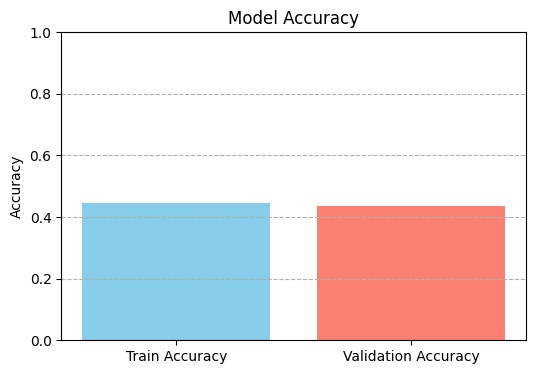

In [6]:
# Accuracy comparison bar plot
plt.figure(figsize=(6, 4))
plt.bar(['Train Accuracy', 'Validation Accuracy'], [train_acc, val_acc], color=['skyblue', 'salmon'])
plt.ylim(0, 1)
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis='y', linestyle='--')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print("Classification Report:\n")
print(classification_report(y_val, y_val_pred))
